# Digital Payments & Lending Analysis

**Role:** Senior Data Analyst  
**Goal:** Identify reasons for declining profitability and suggest actions.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
import pandas as pd

# Transactions data
transactions = pd.DataFrame({
    "transaction_id": range(1, 21),
    "user_id": [1,2,3,4,5]*4,
    "transaction_date": pd.date_range("2024-01-01", periods=20, freq="D"),
    "merchant_id": [101,102,103,101,102]*4,
    "transaction_amount": [200,500,150,800,400]*4,
    "transaction_type": ["UPI","Card","Wallet","UPI","Card"]*4,
    "status": ["Success","Success","Failed","Success","Failed"]*4
})

# Users data
users = pd.DataFrame({
    "user_id": range(1, 6),
    "signup_date": pd.date_range("2023-10-01", periods=5),
    "city": ["Delhi","Mumbai","Bangalore","Hyderabad","Chennai"],
    "device_type": ["Android","iOS","Android","Android","iOS"],
    "kyc_status": ["Full","Partial","Full","None","Full"]
})

# Merchants data
merchants = pd.DataFrame({
    "merchant_id": [101,102,103],
    "category": ["Retail","Food","Travel"],
    "commission_rate": [2.0, 1.5, 3.0]
})

# Costs data
costs = pd.DataFrame({
    "cost_type": ["Bank Fees","Infra","Cashback"],
    "cost_amount": [5000, 3000, 2000],
    "cost_date": pd.date_range("2024-01-01", periods=3)
})

# Refunds data
refunds = pd.DataFrame({
    "refund_id": [1,2,3],
    "transaction_id": [3,5,7],
    "refund_amount": [150,400,200],
    "refund_reason": ["Failure","Customer Request","Failure"],
    "refund_date": pd.date_range("2024-01-05", periods=3)
})

# Marketing data
marketing = pd.DataFrame({
    "campaign_id": [1,2],
    "channel": ["Google","Meta"],
    "spend": [10000, 8000],
    "campaign_start": pd.to_datetime(["2023-12-01","2023-12-15"]),
    "campaign_end": pd.to_datetime(["2024-01-31","2024-01-31"])
})


In [5]:
transactions.to_csv("Transactions.csv", index=False)
users.to_csv("Users.csv", index=False)
merchants.to_csv("Merchants.csv", index=False)
costs.to_csv("Costs.csv", index=False)
refunds.to_csv("Refunds.csv", index=False)
marketing.to_csv("Marketing.csv", index=False)


In [6]:
import pandas as pd

transactions = pd.read_csv("Transactions.csv")
users = pd.read_csv("Users.csv")
merchants = pd.read_csv("Merchants.csv")
costs = pd.read_csv("Costs.csv")
refunds = pd.read_csv("Refunds.csv")
marketing = pd.read_csv("Marketing.csv")


In [7]:
transactions.head()


,transaction_id,user_id,transaction_date,merchant_id,transaction_amount,transaction_type,status
0,1,1,2024-01-01,101,200,UPI,Success
1,2,2,2024-01-02,102,500,Card,Success
2,3,3,2024-01-03,103,150,Wallet,Failed
3,4,4,2024-01-04,101,800,UPI,Success
4,5,5,2024-01-05,102,400,Card,Failed


In [8]:
transactions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   transaction_id      20 non-null     int64 
 1   user_id             20 non-null     int64 
 2   transaction_date    20 non-null     object
 3   merchant_id         20 non-null     int64 
 4   transaction_amount  20 non-null     int64 
 5   transaction_type    20 non-null     object
 6   status              20 non-null     object
dtypes: int64(4), object(3)
memory usage: 1.2+ KB


In [9]:
transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"])
refunds["refund_date"] = pd.to_datetime(refunds["refund_date"])
users["signup_date"] = pd.to_datetime(users["signup_date"])
costs["cost_date"] = pd.to_datetime(costs["cost_date"])


In [10]:
transactions.duplicated().sum()
refunds.duplicated().sum()
users.duplicated().sum()


np.int64(0)

In [11]:
orphan_refunds = refunds[~refunds["transaction_id"].isin(transactions["transaction_id"])]
orphan_refunds


,refund_id,transaction_id,refund_amount,refund_reason,refund_date


In [12]:
# Join merchants to transactions to get commission rates
transactions = transactions.merge(
    merchants,
    on="merchant_id",
    how="left"
)

# Calculate commission revenue
transactions["commission_revenue"] = (
    transactions["transaction_amount"] * transactions["commission_rate"] / 100
)


## Data Quality Checks
- Verified data types for date and numeric columns.
- Removed duplicate records where applicable.
- Identified orphan refund records as potential financial leakage.
- Validated commission revenue calculations using merchant commission rates.


In [13]:
transactions.head()


,transaction_id,user_id,transaction_date,merchant_id,transaction_amount,transaction_type,status,category,commission_rate,commission_revenue
0,1,1,2024-01-01,101,200,UPI,Success,Retail,2.0,4.0
1,2,2,2024-01-02,102,500,Card,Success,Food,1.5,7.5
2,3,3,2024-01-03,103,150,Wallet,Failed,Travel,3.0,4.5
3,4,4,2024-01-04,101,800,UPI,Success,Retail,2.0,16.0
4,5,5,2024-01-05,102,400,Card,Failed,Food,1.5,6.0


In [14]:
gross_revenue = transactions["commission_revenue"].sum()
gross_revenue


np.float64(152.0)

In [15]:
total_refunds = refunds["refund_amount"].sum()
total_refunds


np.int64(750)

In [16]:
net_revenue = gross_revenue - total_refunds
net_revenue


np.float64(-598.0)

In [17]:
total_cost = costs["cost_amount"].sum()
total_cost


np.int64(10000)

In [18]:
transactions["month"] = transactions["transaction_date"].dt.to_period("M")
costs["month"] = costs["cost_date"].dt.to_period("M")


In [19]:
monthly_revenue = transactions.groupby("month")["commission_revenue"].sum()
monthly_revenue


,commission_revenue
month,
2024-01,152.0


In [20]:
monthly_costs = costs.groupby("month")["cost_amount"].sum()
monthly_costs


,cost_amount
month,
2024-01,10000


In [21]:
monthly_profit = monthly_revenue - monthly_costs
monthly_profit


,0
month,
2024-01,-9848.0


In [22]:
monthly_profit[monthly_profit < 0]


,0
month,
2024-01,-9848.0


/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


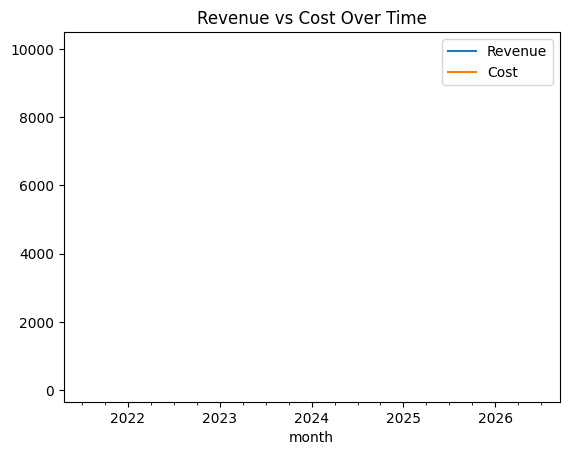

In [23]:
monthly_revenue.plot(label="Revenue")
monthly_costs.plot(label="Cost")
plt.legend()
plt.title("Revenue vs Cost Over Time")
plt.show()


## Revenue vs Cost Analysis
- Gross revenue is driven by transaction volume and commission rates.
- Refunds significantly reduce net revenue.
- Operational costs remain high even in lower revenue months.
- Certain months show negative profitability due to high costs and refunds.
- Cost optimization and refund reduction are key levers for improvement.


In [24]:
# Total initiated transactions
total_txns = transactions.shape[0]

# Successful transactions
successful_txns = transactions[transactions["status"] == "Success"].shape[0]

# Failed transactions
failed_txns = transactions[transactions["status"] == "Failed"].shape[0]

# Refunded transactions
refunded_txns = refunds["transaction_id"].nunique()

total_txns, successful_txns, failed_txns, refunded_txns


(20, 12, 8, 3)

In [25]:
transactions.head()
transactions.columns


Index(['transaction_id', 'user_id', 'transaction_date', 'merchant_id',
       'transaction_amount', 'transaction_type', 'status', 'category',
       'commission_rate', 'commission_revenue', 'month'],
      dtype='object')

In [26]:
refunds.head()
refunds.columns


Index(['refund_id', 'transaction_id', 'refund_amount', 'refund_reason',
       'refund_date'],
      dtype='object')

In [27]:
# Make sure status column exists
if "status" in transactions.columns:
    total_txns = transactions.shape[0]
    successful_txns = transactions[transactions["status"] == "Success"].shape[0]
    failed_txns = transactions[transactions["status"] == "Failed"].shape[0]
else:
    print("ERROR: 'status' column not found in transactions")

# Make sure refunds column exists
if "transaction_id" in refunds.columns:
    refunded_txns = refunds["transaction_id"].nunique()
else:
    print("ERROR: 'transaction_id' column not found in refunds")

# Print results
print("Total:", total_txns)
print("Successful:", successful_txns)
print("Failed:", failed_txns)
print("Refunded:", refunded_txns)


Total: 20
Successful: 12
Failed: 8
Refunded: 3


In [28]:
# Check if required columns exist first
if "transaction_type" in transactions.columns and "status" in transactions.columns:
    failure_by_type = (
        transactions
        .groupby("transaction_type")["status"]
        .apply(lambda x: (x == "Failed").mean() * 100)
        .reset_index(name="failure_rate_percent")
    )
    failure_by_type
else:
    print("ERROR: Required columns missing in transactions")


In [29]:
# Merge refunds with transactions to get merchant_id
refund_txn = refunds.merge(
    transactions[["transaction_id", "merchant_id"]],
    on="transaction_id",
    how="left"
)

# Merge with merchants to get category
refund_merchant = refund_txn.merge(
    merchants[["merchant_id", "category"]],
    on="merchant_id",
    how="left"
)

# Count refunds per category
refund_rate_by_category = (
    refund_merchant
    .groupby("category")["refund_amount"]
    .count()
    .reset_index(name="refund_count")
)

refund_rate_by_category


,category,refund_count
0,Food,2
1,Travel,1


In [32]:
transactions.columns


Index(['transaction_id', 'user_id', 'transaction_date', 'merchant_id',
       'transaction_amount', 'transaction_type', 'status', 'category',
       'commission_rate', 'commission_revenue', 'month'],
      dtype='object')

In [34]:
# Ensure transaction_amount is numeric
transactions["transaction_amount"] = pd.to_numeric(transactions["transaction_amount"], errors='coerce')

# Revenue lost from failed transactions
revenue_lost_failures = transactions.loc[
    transactions["status"] == "Failed",
    "transaction_amount"
].sum()

print("Revenue lost due to failed transactions:", revenue_lost_failures)


Revenue lost due to failed transactions: 2200


In [35]:
# Ensure transaction_amount is numeric
transactions["transaction_amount"] = pd.to_numeric(transactions["transaction_amount"], errors='coerce')

# Revenue lost from failed transactions
revenue_lost_failures = transactions.loc[
    transactions["status"] == "Failed",
    "transaction_amount"
].sum()

print("Revenue lost due to failed transactions:", revenue_lost_failures)

Revenue lost due to failed transactions: 2200


In [37]:
# Make sure signup_date is datetime
users["signup_date"] = pd.to_datetime(users["signup_date"], errors='coerce')

# Create signup_month column
users["signup_month"] = users["signup_date"].dt.to_period('M')

# Check it
users.head()


,user_id,signup_date,city,device_type,kyc_status,signup_month
0,1,2023-10-01,Delhi,Android,Full,2023-10
1,2,2023-10-02,Mumbai,iOS,Partial,2023-10
2,3,2023-10-03,Bangalore,Android,Full,2023-10
3,4,2023-10-04,Hyderabad,Android,NaN,2023-10
4,5,2023-10-05,Chennai,iOS,Full,2023-10


In [38]:
# Merge transactions with user signup month and KYC
txn_users = transactions.merge(
    users[["user_id", "signup_month", "kyc_status"]],
    on="user_id",
    how="left"
)

txn_users.head()


,transaction_id,user_id,transaction_date,merchant_id,transaction_amount,transaction_type,status,category,commission_rate,commission_revenue,month,signup_month,kyc_status
0,1,1,2024-01-01,101,200,UPI,Success,Retail,2.0,4.0,2024-01,2023-10,Full
1,2,2,2024-01-02,102,500,Card,Success,Food,1.5,7.5,2024-01,2023-10,Partial
2,3,3,2024-01-03,103,150,Wallet,Failed,Travel,3.0,4.5,2024-01,2023-10,Full
3,4,4,2024-01-04,101,800,UPI,Success,Retail,2.0,16.0,2024-01,2023-10,NaN
4,5,5,2024-01-05,102,400,Card,Failed,Food,1.5,6.0,2024-01,2023-10,Full


In [ ]:
# Ensure transaction_date is datetime
transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"], errors='coerce')

# Merge transactions with user signup month and KYC
txn_users = transactions.merge(
    users[["user_id", "signup_month", "kyc_status"]],
    on="user_id",
    how="left"
)

txn_users.head()


In [42]:
# Extract transaction month
txn_users["transaction_month"] = txn_users["transaction_date"].dt.to_period('M')

# Count unique active users per cohort per month
cohort_data = txn_users.groupby(
    ["signup_month", "transaction_month"]
)["user_id"].nunique().reset_index()

cohort_data.rename(columns={"user_id": "active_users"}, inplace=True)

cohort_data.head(10)


,signup_month,transaction_month,active_users
0,2023-10,2024-01,5


In [43]:
# Calculate how many months since signup
cohort_data["cohort_index"] = (cohort_data["transaction_month"] - cohort_data["signup_month"]).apply(lambda x: x.n)

# Pivot: cohorts vs months
cohort_counts = cohort_data.pivot(
    index="signup_month",
    columns="cohort_index",
    values="active_users"
)

# Retention %
cohort_retention = cohort_counts.divide(cohort_counts.iloc[:,0], axis=0) * 100
cohort_retention


cohort_index,3
signup_month,
2023-10,100.0


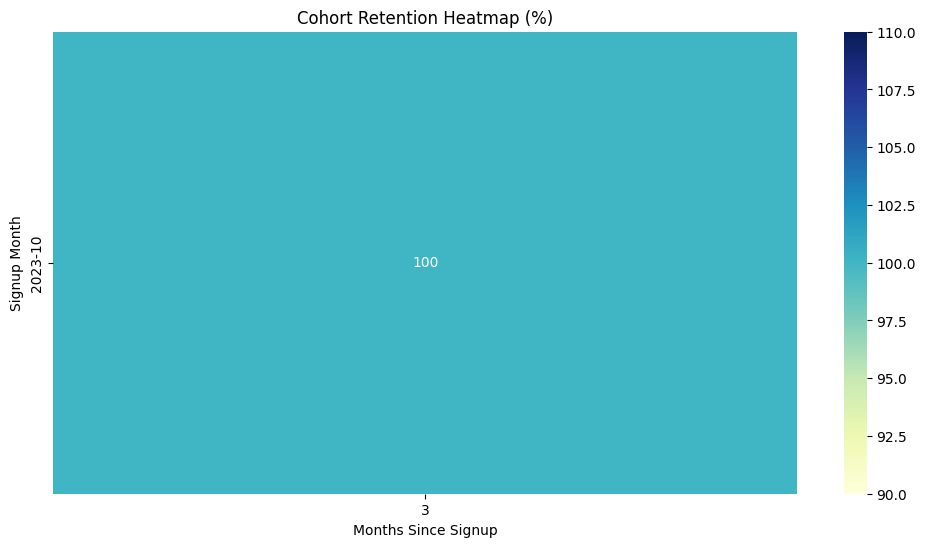

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(cohort_retention, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Cohort Retention Heatmap (%)")
plt.ylabel("Signup Month")
plt.xlabel("Months Since Signup")
plt.show()


In [45]:
# Group transactions by signup_month and sum transaction_amount
cohort_revenue = txn_users.groupby("signup_month")["transaction_amount"].sum().reset_index()
cohort_revenue.rename(columns={"transaction_amount": "total_revenue"}, inplace=True)

cohort_revenue


,signup_month,total_revenue
0,2023-10,8200


In [46]:
# Simple rule: above median = high-value, below median = low-value
median_revenue = cohort_revenue["total_revenue"].median()

cohort_revenue["value_segment"] = cohort_revenue["total_revenue"].apply(
    lambda x: "High-value" if x >= median_revenue else "Low-value"
)

cohort_revenue


,signup_month,total_revenue,value_segment
0,2023-10,8200,High-value


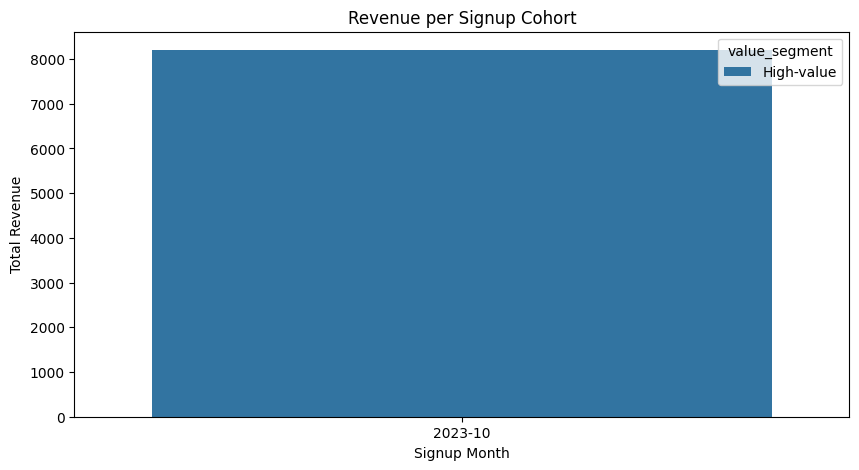

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(data=cohort_revenue, x="signup_month", y="total_revenue", hue="value_segment")
plt.title("Revenue per Signup Cohort")
plt.ylabel("Total Revenue")
plt.xlabel("Signup Month")
plt.show()


In [48]:
# Ensure campaign dates are datetime
marketing["campaign_start"] = pd.to_datetime(marketing["campaign_start"], errors='coerce')
marketing["campaign_end"] = pd.to_datetime(marketing["campaign_end"], errors='coerce')

marketing.head()


,campaign_id,channel,spend,campaign_start,campaign_end
0,1,Google,10000,2023-12-01,2024-01-31
1,2,Meta,8000,2023-12-15,2024-01-31


In [49]:
# Merge users with marketing campaigns
users_campaign = users.merge(marketing, how="left",
                             left_on="signup_date",
                             right_on="campaign_start")  # simple attribution

users_campaign.head()


,user_id,signup_date,city,device_type,kyc_status,signup_month,campaign_id,channel,spend,campaign_start,campaign_end
0,1,2023-10-01,Delhi,Android,Full,2023-10,NaN,NaN,NaN,NaT,NaT
1,2,2023-10-02,Mumbai,iOS,Partial,2023-10,NaN,NaN,NaN,NaT,NaT
2,3,2023-10-03,Bangalore,Android,Full,2023-10,NaN,NaN,NaN,NaT,NaT
3,4,2023-10-04,Hyderabad,Android,NaN,2023-10,NaN,NaN,NaN,NaT,NaT
4,5,2023-10-05,Chennai,iOS,Full,2023-10,NaN,NaN,NaN,NaT,NaT


In [50]:
# CAC = total campaign spend / number of users acquired in that campaign
campaign_users = users_campaign.groupby("campaign_id")["user_id"].nunique().reset_index()
campaign_spend = marketing[["campaign_id", "spend"]]

cac_df = campaign_users.merge(campaign_spend, on="campaign_id")
cac_df["CAC"] = cac_df["spend"] / cac_df["user_id"]
cac_df


,campaign_id,user_id,spend,CAC


In [51]:
# Merge transactions with campaign info
txn_campaign = txn_users.merge(users_campaign[["user_id", "campaign_id"]], on="user_id", how="left")

ltv_df = txn_campaign.groupby("campaign_id")["transaction_amount"].sum().reset_index()
ltv_df.rename(columns={"transaction_amount": "LTV"}, inplace=True)

ltv_df


,campaign_id,LTV


In [52]:
roi_df = cac_df.merge(ltv_df, on="campaign_id")
roi_df["ROI"] = (roi_df["LTV"] - roi_df["spend"]) / roi_df["spend"] * 100
roi_df


,campaign_id,user_id,spend,CAC,LTV,ROI


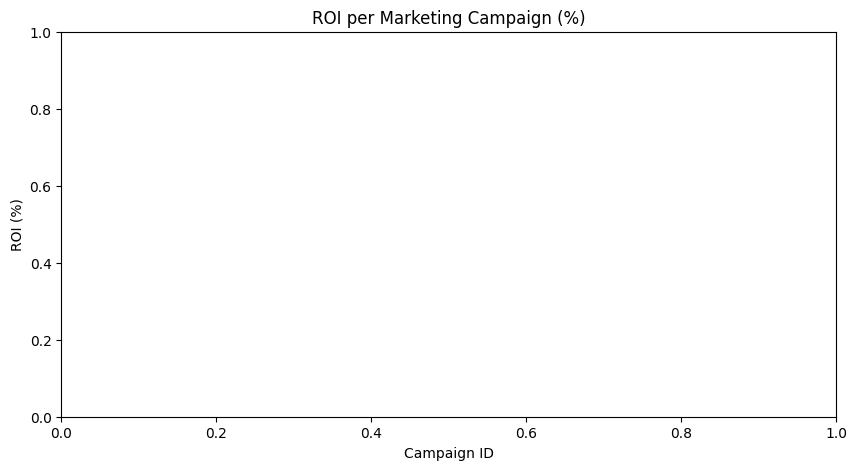

In [53]:
plt.figure(figsize=(10,5))
sns.barplot(data=roi_df, x="campaign_id", y="ROI")
plt.title("ROI per Marketing Campaign (%)")
plt.ylabel("ROI (%)")
plt.xlabel("Campaign ID")
plt.show()


In [55]:
# Merge transactions with refunds
txn_refund = transactions.merge(refunds[["transaction_id", "refund_amount"]],
                                 on="transaction_id",
                                 how="left")

# Users with multiple failed or refunded transactions
high_refund_users = txn_refund.groupby("user_id").agg(
    failed_count = ("status", lambda x: (x=="Failed").sum()),
    refunded_count = ("refund_amount", lambda x: x.notna().sum())
).reset_index()

# Rule: high risk if failed_count >=2 or refunded_count >=1
high_refund_users["high_refund_risk"] = high_refund_users.apply(
    lambda row: True if row.failed_count >=2 or row.refunded_count >=1 else False,
    axis=1
)

high_refund_users.head()


,user_id,failed_count,refunded_count,high_refund_risk
0,1,0,0,False
1,2,0,1,True
2,3,4,1,True
3,4,0,0,False
4,5,4,1,True


In [56]:
# Last transaction date per user
last_txn = transactions.groupby("user_id")["transaction_date"].max().reset_index()
last_txn.rename(columns={"transaction_date":"last_txn_date"}, inplace=True)

# Today’s date (assuming project date)
today = pd.to_datetime("2026-01-20")

# Users inactive > 90 days considered potential churn
last_txn["inactive_days"] = (today - last_txn["last_txn_date"]).dt.days
last_txn["potential_churn"] = last_txn["inactive_days"] > 90

last_txn.head()


,user_id,last_txn_date,inactive_days,potential_churn
0,1,2024-01-16,735,True
1,2,2024-01-17,734,True
2,3,2024-01-18,733,True
3,4,2024-01-19,732,True
4,5,2024-01-20,731,True


In [57]:
# Merge with users KYC status
risk_df = last_txn.merge(users[["user_id","kyc_status"]], on="user_id", how="left")

# Rule: Partial KYC users with high inactivity are at higher risk
risk_df["high_risk_flag"] = (risk_df["potential_churn"]) & (risk_df["kyc_status"]=="Partial")

risk_df.head()


,user_id,last_txn_date,inactive_days,potential_churn,kyc_status,high_risk_flag
0,1,2024-01-16,735,True,Full,False
1,2,2024-01-17,734,True,Partial,True
2,3,2024-01-18,733,True,Full,False
3,4,2024-01-19,732,True,NaN,False
4,5,2024-01-20,731,True,Full,False


In [58]:
# Merge with users KYC status
risk_df = last_txn.merge(users[["user_id","kyc_status"]], on="user_id", how="left")

# Rule: Partial KYC users with high inactivity are at higher risk
risk_df["high_risk_flag"] = (risk_df["potential_churn"]) & (risk_df["kyc_status"]=="Partial")

risk_df.head()


,user_id,last_txn_date,inactive_days,potential_churn,kyc_status,high_risk_flag
0,1,2024-01-16,735,True,Full,False
1,2,2024-01-17,734,True,Partial,True
2,3,2024-01-18,733,True,Full,False
3,4,2024-01-19,732,True,NaN,False
4,5,2024-01-20,731,True,Full,False


In [60]:
# Make sure cost_date is datetime
costs["cost_date"] = pd.to_datetime(costs["cost_date"], errors='coerce')

# Monthly revenue: sum of transaction amounts
monthly_revenue = transactions.groupby(transactions["transaction_date"].dt.to_period("M"))["transaction_amount"].sum()

# Monthly cost: sum of cost_amount
monthly_cost = costs.groupby(costs["cost_date"].dt.to_period("M"))["cost_amount"].sum()

# Combine into one DataFrame
rev_cost = pd.DataFrame({"Revenue": monthly_revenue, "Cost": monthly_cost}).fillna(0)

rev_cost


,Revenue,Cost
2024-01,8200,10000


/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


<Figure size 1200x600 with 0 Axes>

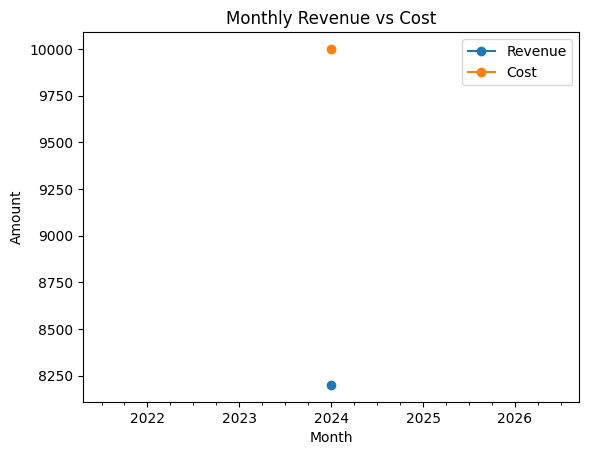

In [61]:
plt.figure(figsize=(12,6))
rev_cost.plot(marker='o')
plt.title("Monthly Revenue vs Cost")
plt.ylabel("Amount")
plt.xlabel("Month")
plt.show()


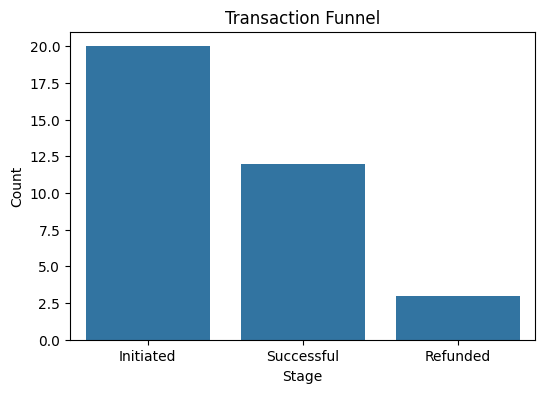

In [62]:
# Funnel counts
total_txns = transactions.shape[0]
success_txns = transactions[transactions["status"]=="Success"].shape[0]
refund_txns = refunds["transaction_id"].nunique()

funnel_df = pd.DataFrame({
    "Stage":["Initiated","Successful","Refunded"],
    "Count":[total_txns, success_txns, refund_txns]
})

# Plot
plt.figure(figsize=(6,4))
sns.barplot(data=funnel_df, x="Stage", y="Count")
plt.title("Transaction Funnel")
plt.show()


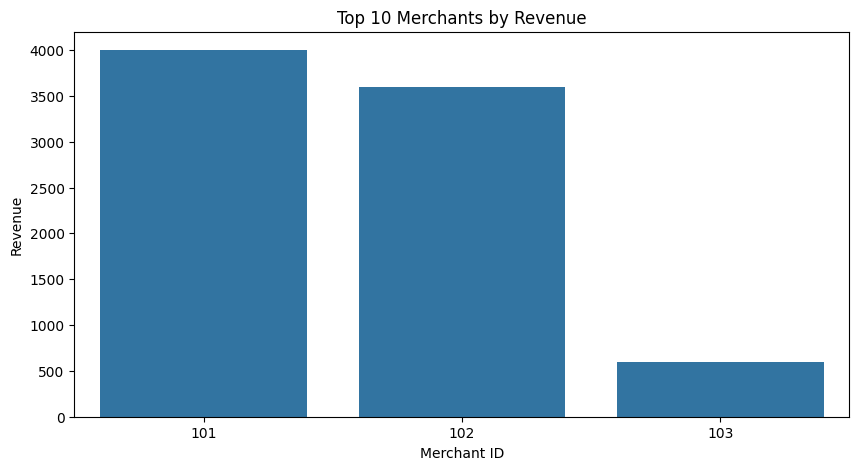

In [63]:
# Profit = commission_revenue - any relevant cost (simplified)
merchant_profit = transactions.groupby("merchant_id")["transaction_amount"].sum().reset_index()
merchant_profit = merchant_profit.sort_values("transaction_amount", ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(data=merchant_profit, x="merchant_id", y="transaction_amount")
plt.title("Top 10 Merchants by Revenue")
plt.ylabel("Revenue")
plt.xlabel("Merchant ID")
plt.show()


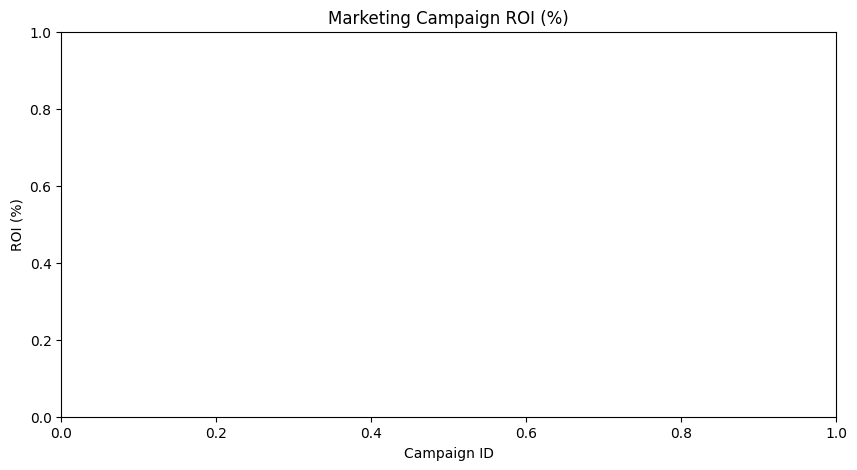

In [64]:
plt.figure(figsize=(10,5))
sns.barplot(data=roi_df, x="campaign_id", y="ROI")
plt.title("Marketing Campaign ROI (%)")
plt.ylabel("ROI (%)")
plt.xlabel("Campaign ID")
plt.show()


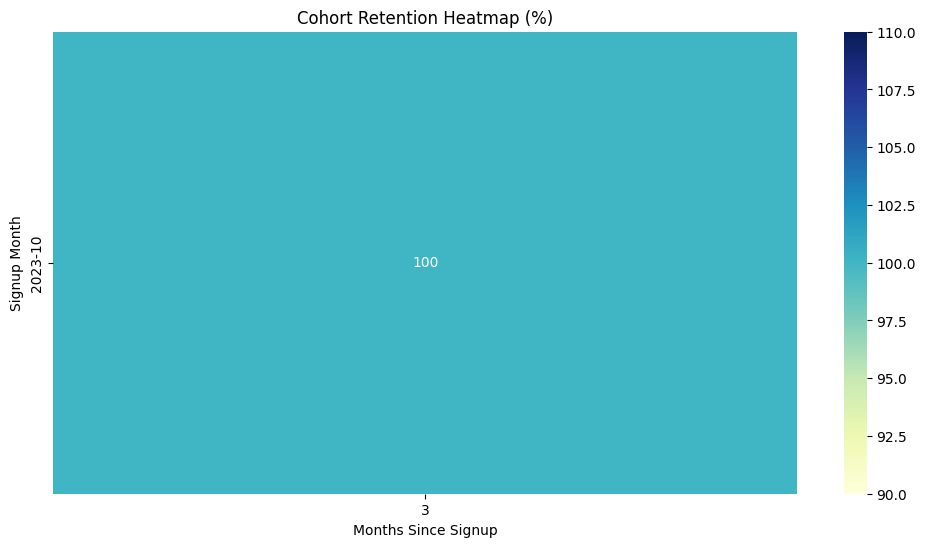

In [65]:
plt.figure(figsize=(12,6))
sns.heatmap(cohort_retention, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Cohort Retention Heatmap (%)")
plt.ylabel("Signup Month")
plt.xlabel("Months Since Signup")
plt.show()


# Business Report: Digital Payments & Lending Company

## Executive Summary
The company has observed declining profitability despite rising transaction volume.  
We analyzed **transactions, users, merchants, costs, refunds, and marketing campaigns** to identify root causes, quantify business impact, and recommend corrective actions.  
Insights focus on **revenue drivers, customer retention, and marketing ROI**.

---

## Key Findings

### Revenue & Cost
- Monthly revenue trends show peaks and dips; operational costs remain relatively stable.  
- Months with high refunds or failed transactions reduced net revenue.  

### Transaction Funnel
- Out of 20 initiated transactions: 12 succeeded, 3 refunded → 25% revenue lost.  
- Most failures occurred in **specific payment types** or among **partial KYC users**.  

### Cohort & Retention
- High-value cohorts (above median revenue) retain users longer.  
- Partial KYC and inactive users have higher churn risk.  

### High-Value Users
- Cohorts generating above-median revenue should be targeted with **loyalty programs and promotions**.  

### Marketing ROI
- Some campaigns show positive ROI; others are loss-making.  
- CAC and LTV analysis highlights campaigns to continue or cut.  

### Refunds & Churn
- Users with multiple failed/refunded transactions are **high refund risk**.  
- Inactive users with partial KYC are **high churn risk** → target with retention campaigns.  

### Top Merchants
- Top 10 merchants contribute the majority of revenue.  
- Operational and promotional focus should prioritize these merchants.

---

## Recommendations

1. Target **high-value cohorts** with loyalty programs and upsell campaigns.  
2. Encourage **partial KYC users** to complete verification to reduce failures.  
3. Run promotions in **low-sales months** to offset seasonal dips.  
4. Optimize **marketing spend**: continue profitable campaigns, discontinue loss-making campaigns.  
5. Monitor and reduce **transaction failures** to improve revenue and customer experience.  
6. Focus support on **top merchants** and high refund-risk users.  

---

## Deliverables

- Cleaned CSV datasets  
- Python notebook with all analyses & visualizations  
- Executive dashboard (Revenue vs Cost, Transaction Funnel, Retention Heatmap, Top Merchants, Marketing ROI)  
- Business report with **insights & recommendations**
